# Random Forest for Creditworthiness Prediction

### Install necessary packages

In [2]:
!pip install ydata-profiling
!pip install imbalanced-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=a46c8ec92d72b207794319d18e180b8d2adf0bc89d17e7224e549c7ac3cf02d6
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


### Import required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from ydata_profiling import ProfileReport

### Load the dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
columns = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount", "Savings",
    "EmploymentSince", "InstallmentRate", "PersonalStatusSex", "DebtorsGuarantors",
    "ResidenceSince", "Property", "Age", "OtherInstallmentPlans", "Housing", "ExistingCredits",
    "Job", "NumPeopleLiable", "Telephone", "ForeignWorker", "CreditRisk"
]

In [5]:
df = pd.read_csv(url, delim_whitespace=True, header=None)
df.columns = columns

In [6]:
df.head(5)

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,DebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumPeopleLiable,Telephone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Initial Data Exploration

In [7]:
# Convert target variable to binary (1 = Good, 0 = Bad)
df['CreditRisk'] = df['CreditRisk'].map({1: 1, 2: 0})

In [10]:
# Show shape and preview
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (1000, 21)


,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,DebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumPeopleLiable,Telephone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [12]:
print("\nData types and missing values:")
df.info()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Status                 1000 non-null   object
 1   Duration               1000 non-null   int64 
 2   CreditHistory          1000 non-null   object
 3   Purpose                1000 non-null   object
 4   CreditAmount           1000 non-null   int64 
 5   Savings                1000 non-null   object
 6   EmploymentSince        1000 non-null   object
 7   InstallmentRate        1000 non-null   int64 
 8   PersonalStatusSex      1000 non-null   object
 9   DebtorsGuarantors      1000 non-null   object
 10  ResidenceSince         1000 non-null   int64 
 11  Property               1000 non-null   object
 12  Age                    1000 non-null   int64 
 13  OtherInstallmentPlans  1000 non-null   object
 14  Housing                1000 non-null   ob

In [13]:
# Check for null values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Status                   0
Duration                 0
CreditHistory            0
Purpose                  0
CreditAmount             0
Savings                  0
EmploymentSince          0
InstallmentRate          0
PersonalStatusSex        0
DebtorsGuarantors        0
ResidenceSince           0
Property                 0
Age                      0
OtherInstallmentPlans    0
Housing                  0
ExistingCredits          0
Job                      0
NumPeopleLiable          0
Telephone                0
ForeignWorker            0
CreditRisk               0
dtype: int64


In [14]:
print("\nSummary statistics:")
print(df.describe(include='all'))


Summary statistics:
       Status     Duration CreditHistory Purpose  CreditAmount Savings  \
count    1000  1000.000000          1000    1000   1000.000000    1000   
unique      4          NaN             5      10           NaN       5   
top       A14          NaN           A32     A43           NaN     A61   
freq      394          NaN           530     280           NaN     603   
mean      NaN    20.903000           NaN     NaN   3271.258000     NaN   
std       NaN    12.058814           NaN     NaN   2822.736876     NaN   
min       NaN     4.000000           NaN     NaN    250.000000     NaN   
25%       NaN    12.000000           NaN     NaN   1365.500000     NaN   
50%       NaN    18.000000           NaN     NaN   2319.500000     NaN   
75%       NaN    24.000000           NaN     NaN   3972.250000     NaN   
max       NaN    72.000000           NaN     NaN  18424.000000     NaN   

       EmploymentSince  InstallmentRate PersonalStatusSex DebtorsGuarantors  \
count      

In [15]:
# Class distribution
print("\nTarget class distribution:\n", df['CreditRisk'].value_counts())


Target class distribution:
 CreditRisk
1    700
0    300
Name: count, dtype: int64


### Data Visualization

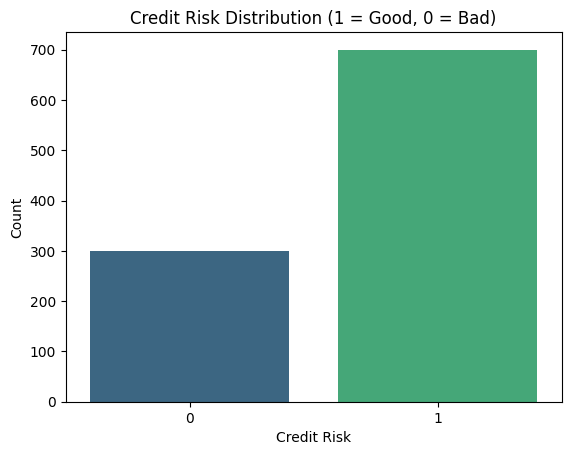

In [16]:
# Plotting class distribution
sns.countplot(x='CreditRisk', data=df, palette='viridis')
plt.title("Credit Risk Distribution (1 = Good, 0 = Bad)")
plt.xlabel("Credit Risk")
plt.ylabel("Count")
plt.show()

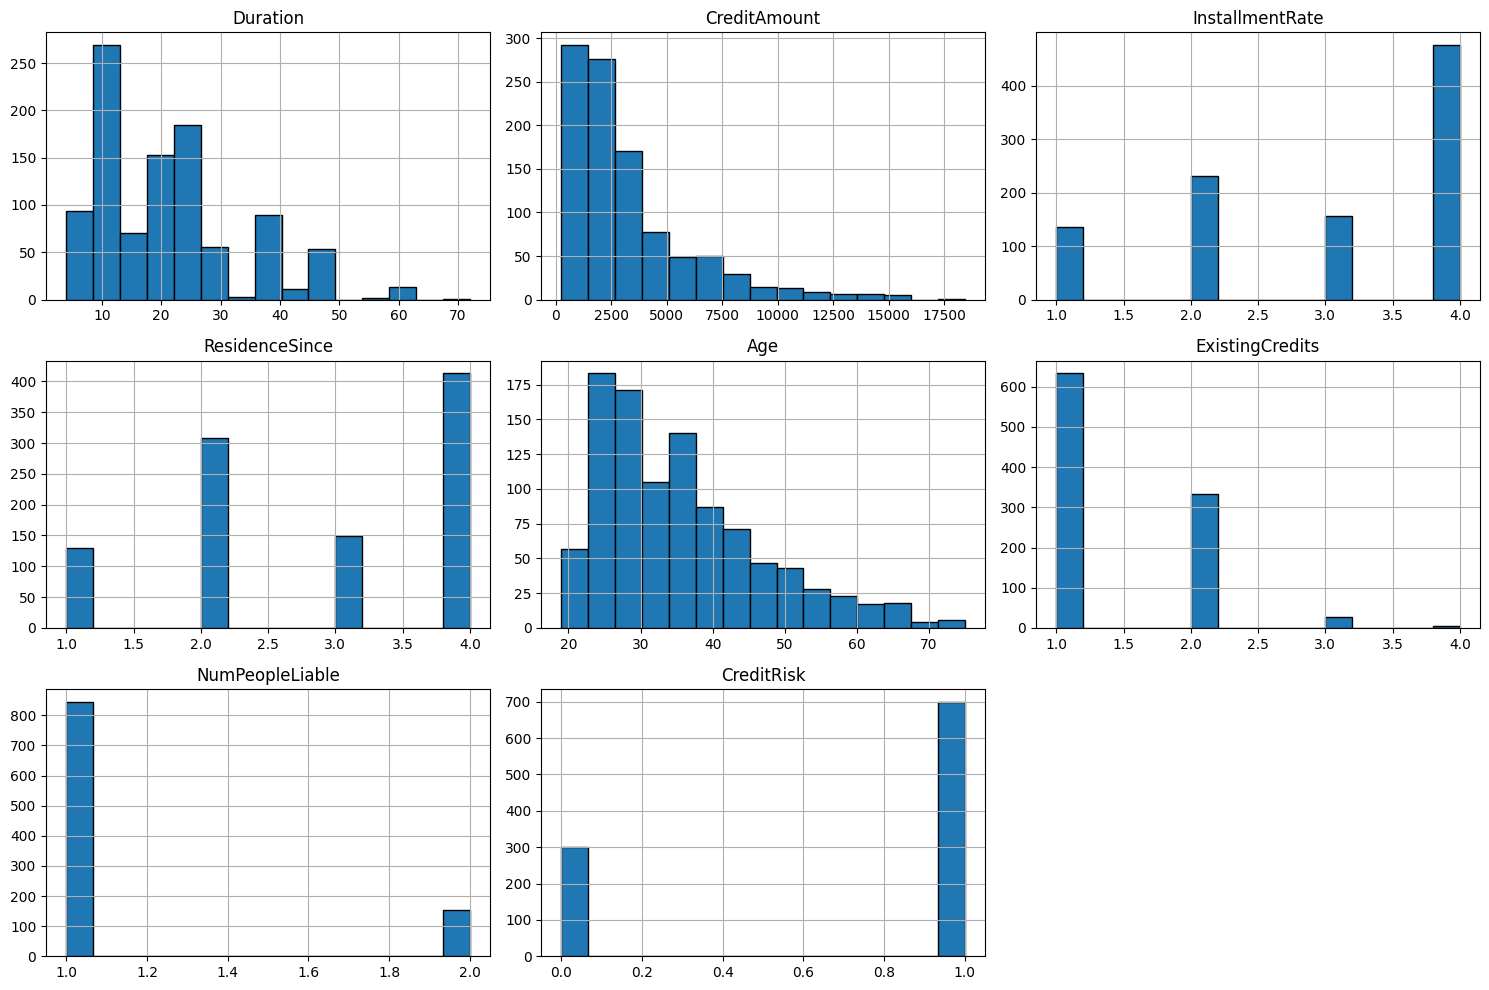

In [17]:
# Select numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[num_cols].hist(bins=15, figsize=(15, 10), layout=(3, 3), edgecolor='black')
plt.tight_layout()
plt.show()

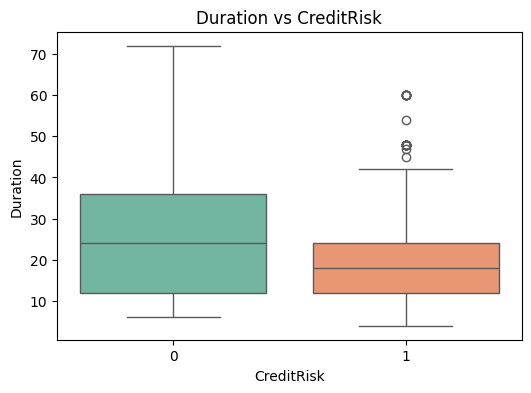

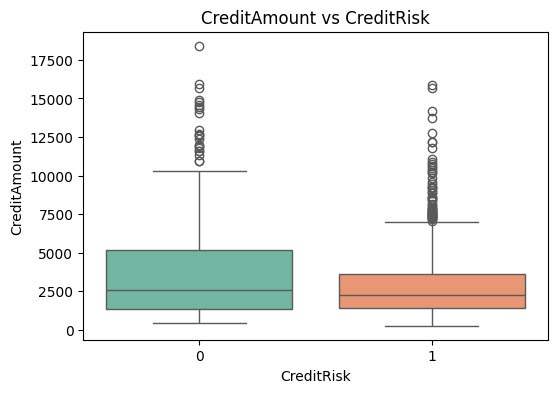

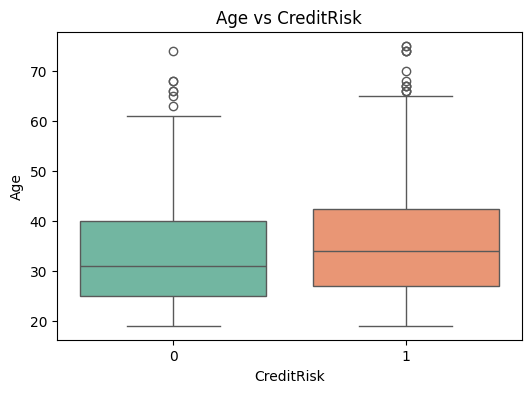

In [18]:
for col in ['Duration', 'CreditAmount', 'Age']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='CreditRisk', y=col, data=df, palette='Set2')
    plt.title(f"{col} vs CreditRisk")
    plt.show()

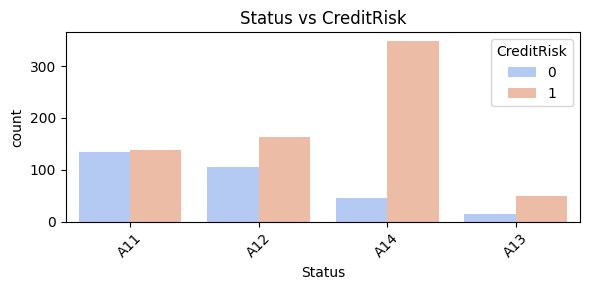

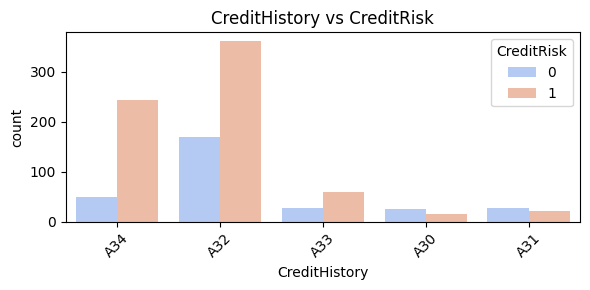

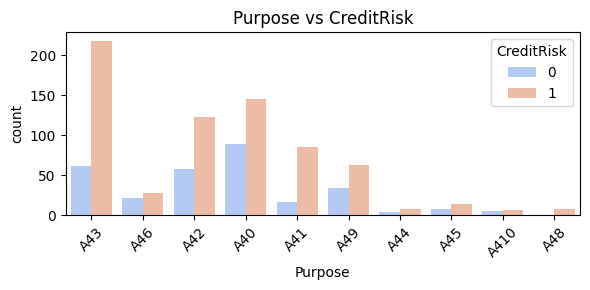

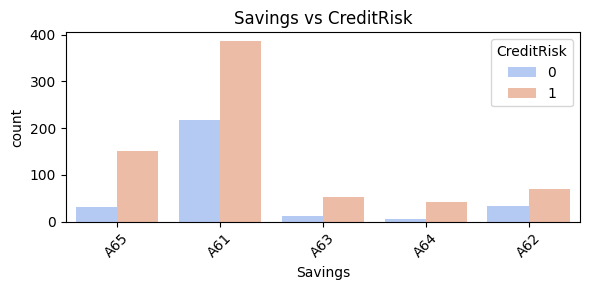

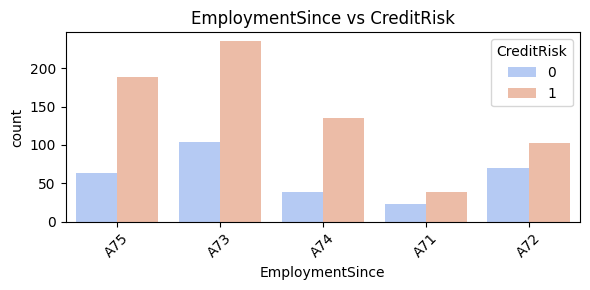

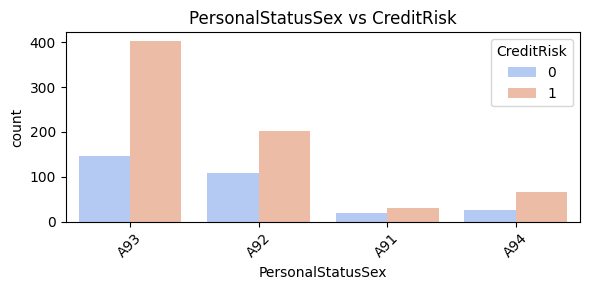

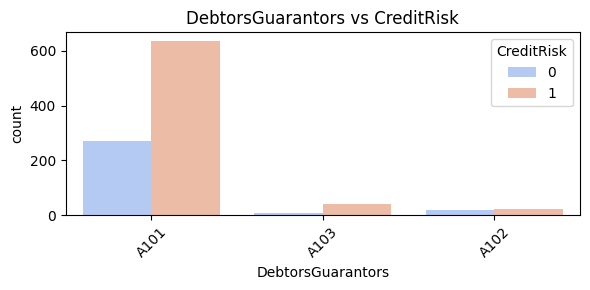

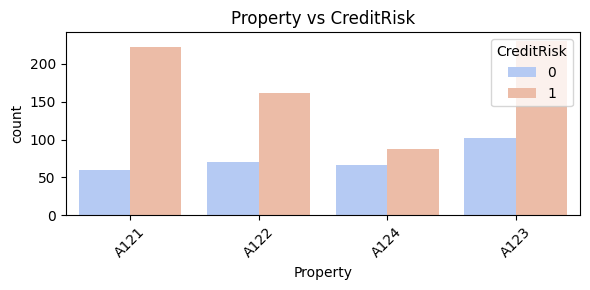

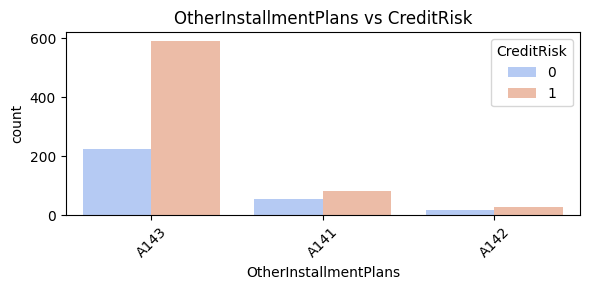

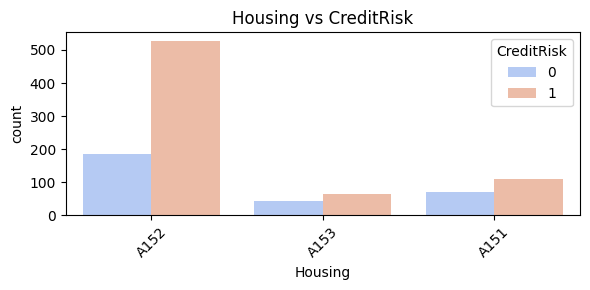

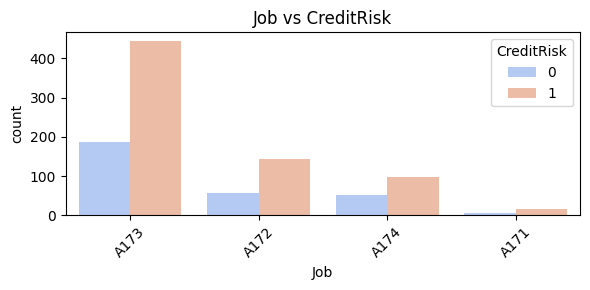

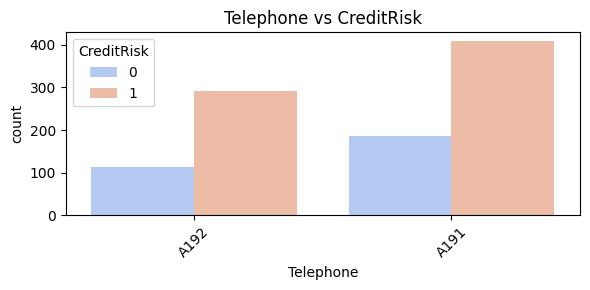

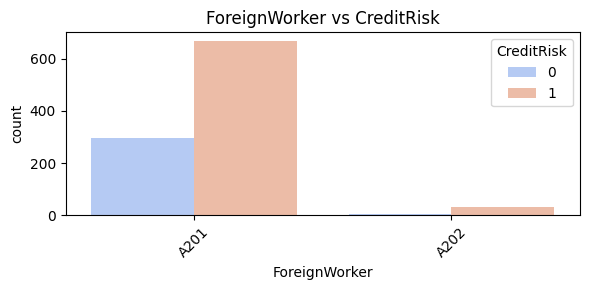

In [19]:
# Categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Plot countplots
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, data=df, hue='CreditRisk', palette='coolwarm')
    plt.title(f'{col} vs CreditRisk')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [20]:
# Run this if you want to generate a full data profiling report
profile = ProfileReport(df, title="German Credit Data Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 37.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# Save the report to an HTML file
profile.to_file("german_credit_profile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
from google.colab import files
files.download("german_credit_profile.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data Preprocessing

In [23]:
# Copying original data
df_encoded = df.copy()

In [24]:
# Encode all categorical columns using Label Encoding
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [25]:
# View the first few rows
df_encoded.head()

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,DebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumPeopleLiable,Telephone,ForeignWorker,CreditRisk
0,0,6,4,4,1169,4,4,4,2,0,...,0,67,2,1,2,2,1,1,0,1
1,1,48,2,4,5951,0,2,2,1,0,...,0,22,2,1,1,2,1,0,0,0
2,3,12,4,7,2096,0,3,2,2,0,...,0,49,2,1,1,1,2,0,0,1
3,0,42,2,3,7882,0,3,2,2,2,...,1,45,2,2,1,2,2,0,0,1
4,0,24,3,0,4870,0,2,3,2,0,...,3,53,2,2,2,2,2,0,0,0


In [26]:
# Features and target
X = df_encoded.drop("CreditRisk", axis=1)
y = df_encoded["CreditRisk"]

In [27]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
# Print class distribution
print("Train Class Distribution:\n", y_train.value_counts())
print("Test Class Distribution:\n", y_test.value_counts())

Train Class Distribution:
 CreditRisk
1    560
0    240
Name: count, dtype: int64
Test Class Distribution:
 CreditRisk
1    140
0     60
Name: count, dtype: int64


### Feature Scaling

In [29]:
# Identify numeric columns (exclude target)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [30]:
# Initialize scaler
scaler = StandardScaler()

In [31]:
# Fit on training and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

In [32]:
# Convert back to DataFrames (optional for inspection)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

In [33]:
# Replace original numeric columns with scaled ones in original dataframes
X_train.update(X_train_scaled_df)
X_test.update(X_test_scaled_df)

In [34]:
# Preview
X_train.head()

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,DebtorsGuarantors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumPeopleLiable,Telephone,ForeignWorker
675,1.110581,0.755149,1.309127,0.263557,0.485384,-0.700616,0.487877,0.905268,-0.946110,-0.30874,1.044365,0.646718,-0.825479,0.451907,-1.783509,-0.719852,1.687664,-0.442509,1.221561,-0.190445
703,-0.464711,0.755149,0.394453,2.096997,-0.246578,-0.068719,1.321855,0.905268,0.460745,-0.30874,-0.758207,-0.311383,0.493705,-1.000003,0.136824,1.035885,0.146418,-0.442509,-0.818625,-0.190445
12,-0.464711,-0.726746,-0.520221,0.263557,-0.584573,-0.700616,-0.346101,-1.797024,-0.946110,-0.30874,-1.659492,0.646718,-1.177262,0.451907,0.136824,-0.719852,0.146418,-0.442509,1.221561,-0.190445
845,-0.464711,0.014201,-0.520221,-0.103131,0.285331,1.826971,0.487877,-0.896260,0.460745,-0.30874,0.143079,0.646718,-0.033969,0.451907,0.136824,-0.719852,0.146418,-0.442509,1.221561,-0.190445
795,1.110581,-0.973728,-0.520221,-0.103131,-0.319522,-0.068719,-1.180079,-0.896260,-0.946110,-0.30874,1.044365,-0.311383,-1.177262,0.451907,-1.783509,-0.719852,0.146418,-0.442509,-0.818625,-0.190445


### Handle Imbalanced Data

In [35]:
print("\nClass distribution before balancing:")
print(y_train.value_counts(normalize=True))


Class distribution before balancing:
CreditRisk
1    0.7
0    0.3
Name: proportion, dtype: float64


In [36]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [26]:
# Option 2: Under-sampling (alternative to SMOTE)
# under_sampler = RandomUnderSampler(random_state=42)
# X_train_res, y_train_res = under_sampler.fit_resample(X_train_processed, y_train)

In [37]:
# Confirm class balance
print("Resampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

Resampled class distribution:
 CreditRisk
1    560
0    560
Name: count, dtype: int64


### Model Training - Random Forest

In [38]:
# Train a basic Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

### Model Evaluation

In [39]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)

In [40]:
# Predict on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

In [41]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.745


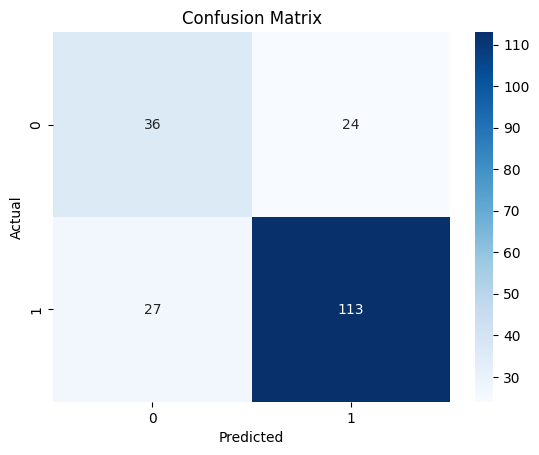

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [43]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.60      0.59        60
           1       0.82      0.81      0.82       140

    accuracy                           0.74       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.75      0.74      0.75       200



In [44]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)

AUC Score: 0.7985119047619047


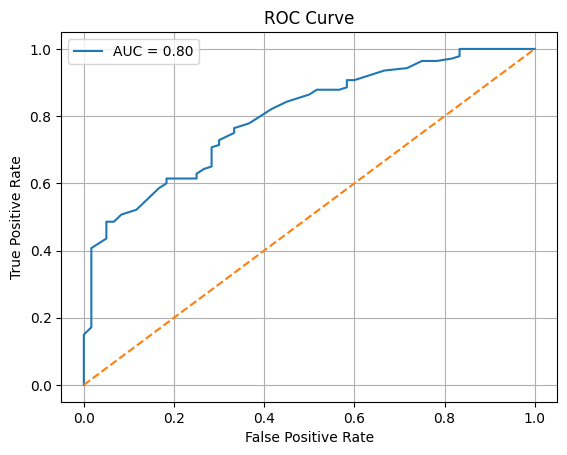

In [45]:
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

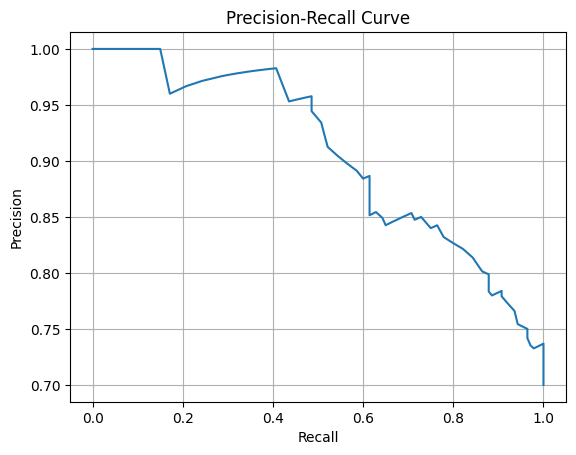

In [46]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label='PR Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

### Hyperparameter Tuning (RandomizedSearchCV)

In [88]:
# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],                      # Reduced from 30 because of overfitting
    'min_samples_split': [5, 10],                   # Increase slightly
    'min_samples_leaf': [2, 4],                     # Increase slightly
    'max_features': ['sqrt'],
    'bootstrap': [True]                             # Set to True for better generalization
}

In [89]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

In [90]:
# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [91]:
# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 15, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1', verbose=1)

In [92]:
# Best model
best_rf = random_search.best_estimator_
print("\nBest Parameters:\n", random_search.best_params_)


Best Parameters:
 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


In [104]:
import joblib

# Save the best model
joblib.dump(best_rf, "tuned_random_forest_model.joblib")

['tuned_random_forest_model.joblib']

In [105]:
# Download the file
files.download("tuned_random_forest_model.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluate Tuned Model

In [96]:
# Check training accuracy
train_pred = best_rf.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_pred))

# Already computed:
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned))

Train Accuracy: 0.96375
Test Accuracy: 0.735


#### We have handled overfitting by adjusting the parameters and iterations.

In [97]:
# Predict on test data using tuned model
y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

In [98]:
# Accuracy
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))

Tuned Model Accuracy: 0.735


Although a previous model had 76% accuracy, it showed signs of overfitting (Train = 100%). After tuning with stricter regularization, the model generalized better (Train = 96%, Test = 73.5%). This makes it more reliable for real-world use.

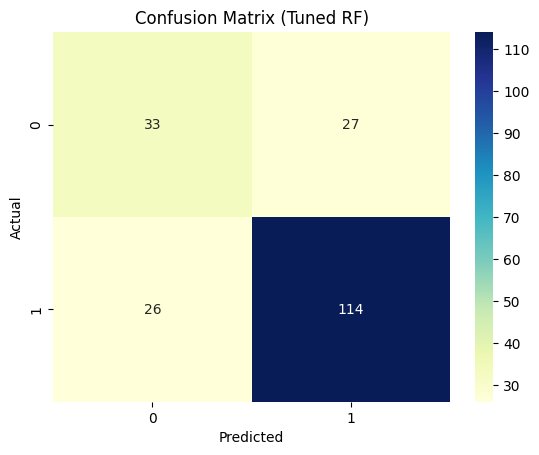

In [99]:
# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix (Tuned RF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [100]:
# Classification Report
print("\nTuned Model Classification Report:\n", classification_report(y_test, y_pred_tuned))


Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.55      0.55        60
           1       0.81      0.81      0.81       140

    accuracy                           0.73       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.73      0.73      0.73       200



Tuned Model AUC Score: 0.7880952380952381


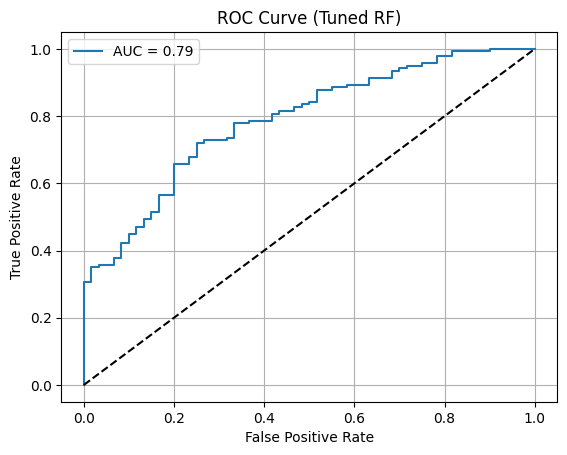

In [101]:
# ROC Curve and AUC
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)
print("Tuned Model AUC Score:", roc_auc_tuned)

plt.plot(fpr_tuned, tpr_tuned, label=f"AUC = {roc_auc_tuned:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned RF)")
plt.legend()
plt.grid(True)
plt.show()

### Cross-validation on the final model

In [102]:
# Use 5-fold CV with F1 scoring
cv_scores = cross_val_score(best_rf, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

print("Cross-Validation F1 Scores:", cv_scores)
print("Average F1 Score:", np.mean(cv_scores))

Cross-Validation F1 Scores: [0.78125    0.78884462 0.87037037 0.89215686 0.9047619 ]
Average F1 Score: 0.8474767518782634


### Feature Importance Plot

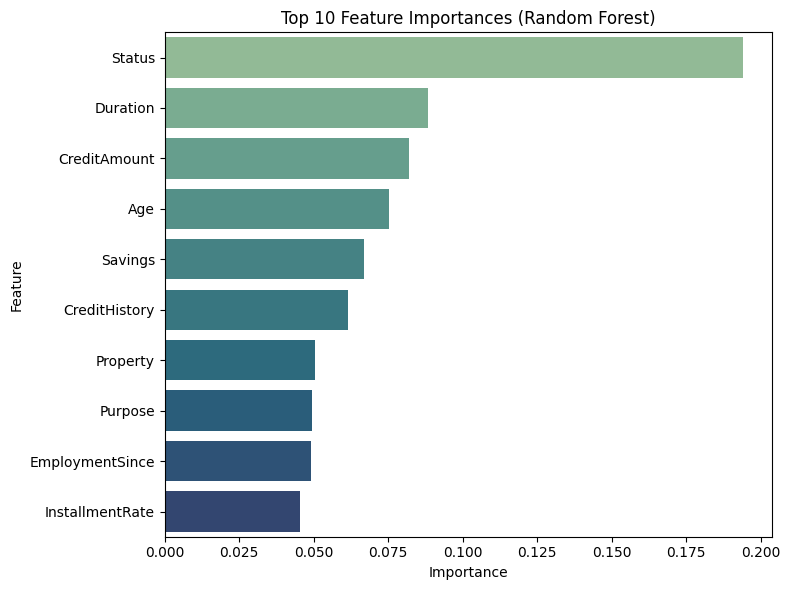

In [103]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Create a sorted DataFrame
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(10), palette='crest')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

## Sample

In [106]:
# ✅ Sample new applicant
new_applicant = {
    "Status": "A14",
    "Duration": 24,
    "CreditHistory": "A34",
    "Purpose": "A43",
    "CreditAmount": 2500,
    "Savings": "A61",
    "EmploymentSince": "A73",
    "InstallmentRate": 4,
    "PersonalStatusSex": "A93",
    "DebtorsGuarantors": "A101",
    "ResidenceSince": 3,
    "Property": "A121",
    "Age": 35,
    "OtherInstallmentPlans": "A143",
    "Housing": "A152",
    "ExistingCredits": 1,
    "Job": "A173",
    "NumPeopleLiable": 1,
    "Telephone": "A191",
    "ForeignWorker": "A201"
}

In [107]:
# Convert to DataFrame
new_app_df = pd.DataFrame([new_applicant])

In [108]:
# Apply label encoders
for col in new_app_df.select_dtypes(include='object').columns:
    le = label_encoders[col]
    new_app_df[col] = le.transform(new_app_df[col])

In [109]:
# Scale numeric features
new_app_df[numeric_cols] = scaler.transform(new_app_df[numeric_cols])

In [110]:
# Predict using trained model
prediction = best_rf.predict(new_app_df)[0]
proba = best_rf.predict_proba(new_app_df)[0][1]

In [111]:
# Show result
if prediction == 1:
    print(f"✅ Approved (Good Credit) - Probability: {proba:.2f}")
else:
    print(f"❌ Rejected (Bad Credit) - Probability: {proba:.2f}")

✅ Approved (Good Credit) - Probability: 0.95
